# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [18]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [20]:
# Handle missing values if any
df = df.dropna()  # Remove rows with missing values

In [30]:
# Encode categorical variables
categorical_cols = ["sales_channel", "trip_type", "flight_day", "booking_origin","route"]
label_encoders = {}  # Store label encoders for each categorical column
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [31]:
# Separate the features (X) and the target variable (y)
X = df.drop("booking_complete", axis=1)  # Replace "target_variable" with the actual name of your target variable column
y = df["booking_complete"]

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

In [56]:
# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

In [36]:
# Make predictions on the testing data
predictions = rf_classifier.predict(X_test)

In [37]:
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8557


In [65]:
# Perform cross-validation and output evaluation metrics
cross_val_scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation
mean_accuracy = np.mean(cross_val_scores)
print("Cross-Validation Accuracy:", mean_accuracy)

Cross-Validation Accuracy: 0.49648000000000003


In [47]:
# Interpret variable contributions using permutation importance
perm_importance = permutation_importance(rf_classifier, X, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

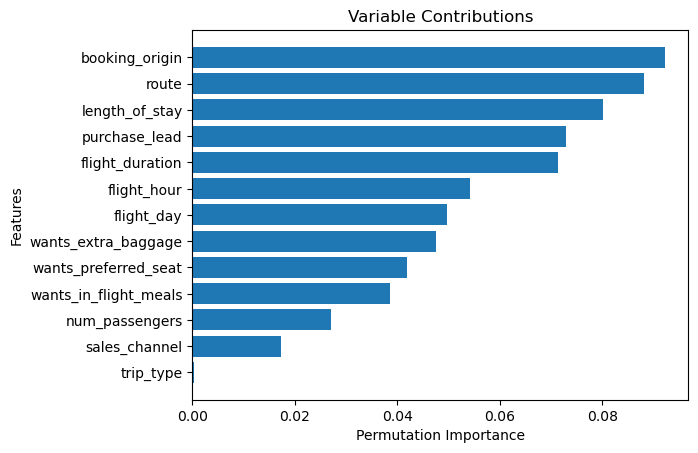

In [49]:
# Create a visualization of variable importances
plt.barh(range(X.shape[1]), perm_importance.importances_mean[sorted_idx], tick_label=X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Variable Contributions")
plt.show()

In [58]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [59]:
# Create a DataFrame with actual and predicted values
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

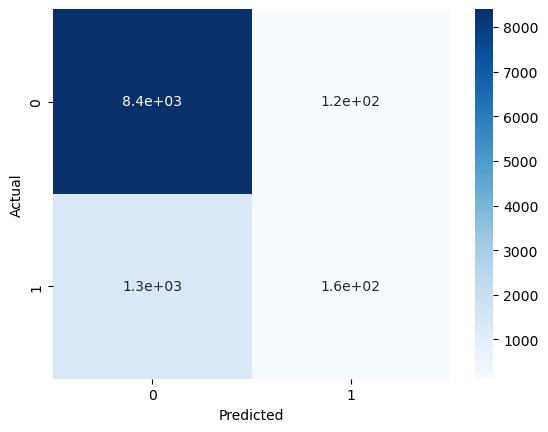

In [62]:
# Create a confusion matrix heatmap using Seaborn
heatmap = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(heatmap, annot=True, cmap='Blues')